In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
dir = 'C:/Users/riach/Projects/age-gender-prediction/data/'

df_age = pd.read_csv(dir+'train_age.csv')
df_gen = pd.read_csv(dir+'train_gender.csv')

print(df_age.head())
print(df_gen.head())

   imageId   age
0        0  89.0
1        1  72.0
2        2  25.0
3        3  68.0
4        4  37.0
   imageId  gender
0        0       0
1        1       0
2        2       1
3        3       1
4        4       0


In [4]:
im=[]
for i in tqdm(sorted(os.listdir(dir+'train/'))):
    img = cv2.imread(dir+'train/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255-img # creating the negative of the image
    img = cv2.resize(img,(128, 128))
    im.append(img)
    #img.append(plt.imread(dir+'kaggle/kaggle/train/'+i))
age = df_age['age']
gen= df_gen['gender']
data ={'Image': im,'Age':age,'Gender':gen}
        

100%|██████████| 10702/10702 [05:56<00:00, 30.01it/s]


In [5]:
df = pd.DataFrame(data)

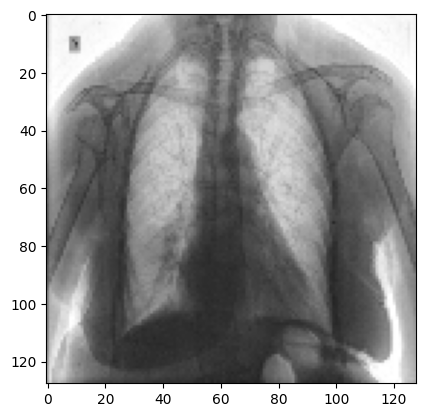

In [6]:
plt.imshow(cv2.cvtColor(df['Image'].iloc[0], cv2.COLOR_BGR2RGB))

# Gender Prediction

In [7]:
X = np.array(data['Image'])
y = np.array(data['Gender'])

X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = y.reshape(-1,1)
X = X/255
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702, 1)


In [17]:
# # datagen = ImageDataGenerator(
# #     rotation_range=20,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
# #     shear_range=0.2,
# #     zoom_range=0.2,
# #     horizontal_flip=True,
# #     fill_mode='nearest'
# # )
# # datagen.fit(X)

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2  # Set the validation split
# )

# batch_size = 32
# train_generator = datagen.flow(X, y, batch_size=batch_size, subset='training')
# validation_generator = datagen.flow(X, y, batch_size=batch_size, subset='validation')


# Gender DCNN model

In [32]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
def blockc(y, filt, kern):
    x = Conv2D(filt, kern, padding='same')(y)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [20]:
tensorflow.keras.backend.clear_session()
inp = Input((128, 128, 1))
c0 = Conv2D(4, 3, padding='same')(inp)
c0 = MaxPool2D(2)(c0)
c1 = blockc(c0, 16, 3)
c2 = blockc(c1, 32, 3)
c3 = blockc(c2, 64, 3)
c4 = blockc(c3, 128, 3)
c5 = blockc(c4, 64, 3)
c6 = blockc(c5, 32, 3)
c6 = GlobalAveragePooling2D()(c6)
out = Dense(1, activation='sigmoid')(c6)
model_gender = Model(inputs=[inp], outputs=[out])

In [21]:
model_gender.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gender.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             

 Total params: 191,257 (747.10 KB)

 Trainable params: 190,585 (744.47 KB)

 Non-trainable params: 672 (2.62 KB)

In [22]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_gender.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 5
)

Epoch 1/5
 952/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9444 - loss: 0.1756

c:\Users\riach\Projects\age-gender-prediction\age\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9439 - loss: 0.1764 - val_accuracy: 0.9285 - val_loss: 0.1633
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9267 - loss: 0.2053 - val_accuracy: 0.9155 - val_loss: 0.1995
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9379 - loss: 0.1906 - val_accuracy: 0.9584 - val_loss: 0.1225
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9323 - loss: 0.1857 - val_accuracy: 0.9678 - val_loss: 0.0997
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9277 - loss: 0.2141 - val_accuracy: 0.9654 - val_loss: 0.0990


<Axes: >

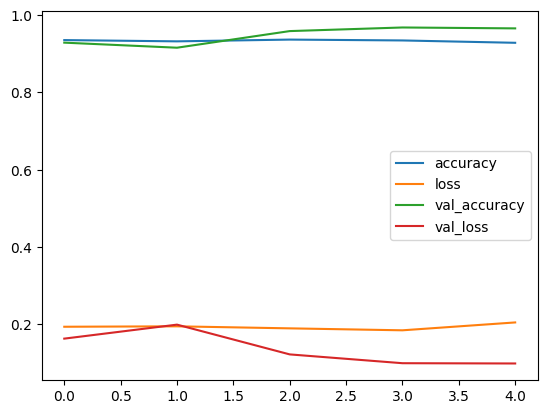

In [29]:
pd.DataFrame(history.history).plot()

In [30]:
model_gender.save('model_gender.h5')

# Age Prediction

In [31]:
y = np.array(data['Age'])
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702,)


In [33]:
tensorflow.keras.backend.clear_session()
inp = Input((128, 128, 1))
c0 = Conv2D(4, 3, padding='same')(inp)
c0 = MaxPool2D(2)(c0)
c1 = blockc(c0, 16, 3)
c2 = blockc(c1, 32, 3)
c3 = blockc(c2, 64, 3)
c4 = blockc(c3, 128, 3)
c5 = blockc(c4, 64, 3)
c6 = blockc(c5, 32, 3)
c6 = GlobalAveragePooling2D()(c6)
c7 = Flatten()(c6)
c8 = Dense(100, activation='linear')(c7)
c9 = Dense(50, activation='linear')(c8)
out = Dense(1, activation='linear')(c9)
model_age = Model(inputs=[inp], outputs=[out])
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [34]:
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model_age.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             

 Total params: 199,625 (779.79 KB)

 Trainable params: 198,953 (777.16 KB)

 Non-trainable params: 672 (2.62 KB)

In [41]:
history = model_age.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 50
)

Epoch 1/50
 952/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 213.7419 - mse: 213.7419

c:\Users\riach\Projects\age-gender-prediction\age\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 213.7201 - mse: 213.7201 - val_loss: 125.4451 - val_mse: 125.4451
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 206.2917 - mse: 206.2917 - val_loss: 178.9972 - val_mse: 178.9972
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 203.6662 - mse: 203.6662 - val_loss: 117.5880 - val_mse: 117.5880
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 195.0295 - mse: 195.0295 - val_loss: 103.8686 - val_mse: 103.8686
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 190.2116 - mse: 190.2116 - val_loss: 121.4320 - val_mse: 121.4320
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 190.6017 - mse: 190.6017 - val_loss: 121.0648 - val_mse: 121.0648
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 182.3713 - mse: 182.3713 - val_loss: 106.1291 - val_mse: 106.1291
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 187.1200 - mse: 187.1200 - val_loss: 

<Axes: >

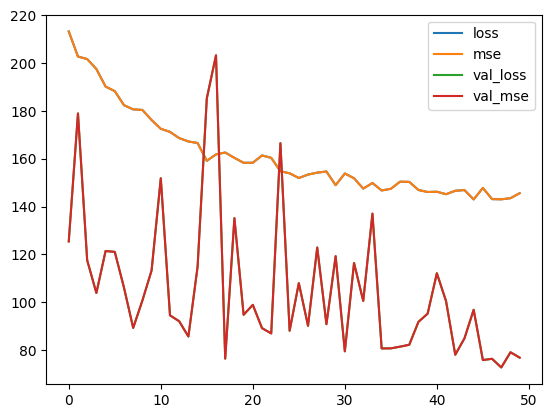

In [42]:
pd.DataFrame(history.history).plot()

In [37]:
model_age.save('model_age.h5')

# Testing the models

In [39]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = model_gender.predict(X)
pred = []
for i in tqdm(y_pred):
    if i<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

print(pred.shape,y.shape)
print(pred[5:15],gen[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


100%|██████████| 10702/10702 [00:00<00:00, 202971.91it/s]

(10702,) (10702,)
[1 1 1 0 1 1 1 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [40]:
pred = np.round(model_age.predict(X))
print(pred[5:15],age[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step
[[74.]
 [45.]
 [41.]
 [67.]
 [43.]
 [72.]
 [72.]
 [54.]
 [69.]
 [42.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


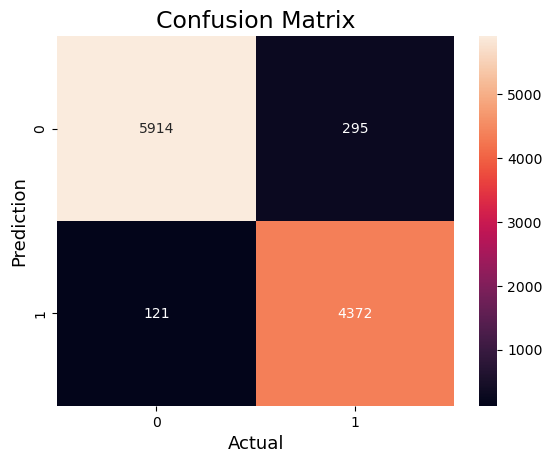

Accuracy   : 0.9611287609792563
Precision : 0.9367902292693379
Recall    : 0.9730692187847764
F1-score  : 0.9545851528384279


In [31]:
import seaborn as sns
cm = confusion_matrix(gen,pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
accuracy = accuracy_score(gen, pred)
print("Accuracy   :", accuracy)
precision = precision_score(gen, pred)
print("Precision :", precision)
recall = recall_score(gen, pred)
print("Recall    :", recall)
F1_score = f1_score(gen, pred)
print("F1-score  :", F1_score)


In [29]:
from sklearn.metrics import r2_score

p = model_age.predict(X)

print(r2_score(age,p))


0.8014806121732889
